# Лабораторная работа "Решение нелинейных систем"

**Вариант: 24**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Имеем систему:

$$\begin{cases}
    \sin(x_1 + x_2) - x_1 + 0.1 & = & 0 \\
    x_2 - \cos(3x_1) + 0.1 & = & 0
    \end{cases}
$$

Уравнения системы:
$$\begin{array}{ccc}
    f_1(x_1, x_2) & = & \sin(x_1 + x_2) - x_1 + 0.1 \\
    f_2(x_1, x_2) & = & x_2 - \cos(3x_1) + 0.1
    \end{array}
$$

Построим линии уровней $f_1$ и $f_2$:

In [3]:
def f1(x1, x2):
    return np.sin(x1 + x2) - x1 + 0.1
def f2(x1, x2):
    return x2 - np.cos(3*x1) + 0.1

In [7]:
def df1_x1(x1, x2):
    return np.cos(x1 + x2) - 1
def df1_x2(x1, x2):
    return np.cos(x1 + x2)

def df2_x1(x1, x2):
    return 3 * np.sin(3*x1)
def df2_x2(x1, x2):
    return 1

In [27]:
x1_range = np.arange(-2.5, 2.5, 0.01)
x2_range = np.arange(-2.5, 2.5, 0.01)

X1, X2 = np.meshgrid(x1_range, x2_range)

In [28]:
f1_vals = f1(X1, X2)
f2_vals = f2(X1, X2)

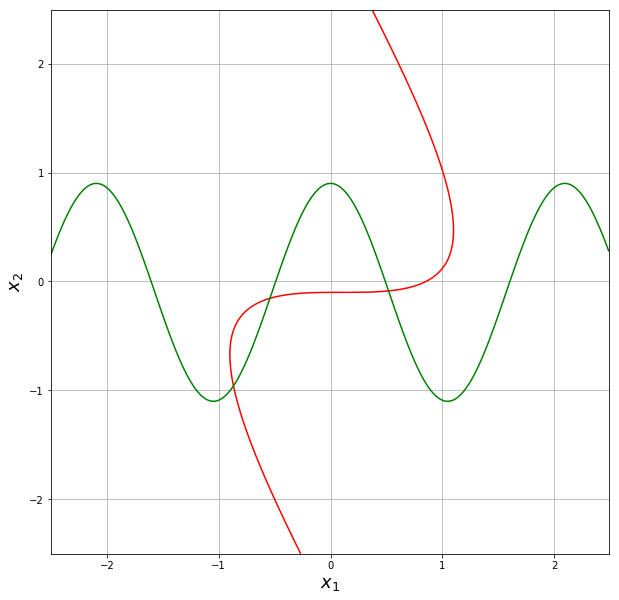

In [37]:
plt.figure(figsize=(10, 10))
plt.contour(X1, X2, f1_vals, [0], colors='r')
plt.contour(X1, X2, f2_vals, [0], colors='g')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.grid(True)

Локализуем корни:

* root1: { $x_1 \in [-1;0], x_2 \in [-1.5; -0.5]$}
* root2: { $x_1 \in [-1;0], x_2 \in [-0.5;0]$}
* root3: { $x_1 \in [0;1], x_2 \in [0;-1]$}

Определим начальные приближения:

* root1: {$ x_{01, root1} = -0.5; x_{02, root1} = -1.5$}
* root2: {$x_{01, root2} = -0.5; x_{02, root2} = -0.4$}
* root3: {$x_{01, root3} = 0.5; x_{02, root3} = -0.5$}

### Реализуем наивный алгоритм Ньютона для нелинейных систем

In [25]:
def mk_jacobi(derivs, args):
    # Number of functions: m
    # Number of arguments of each function: n
    #
    # derivs: [[df1_x1, df1_x2, ..., df1_xn],[df2_x1, ..., df2_xn], ... , [dfm_x1, ..., dfm_xn]]
    # args: [x01, ... x0n]
    #
    # Out: Jacobi matrix
    
    num_funcs = len(derivs)
    num_args = len(args)
    res = np.empty((num_funcs, num_args), dtype=float)
    
    for i in range(num_funcs):

        res[i] = np.array([f(*args) for f in derivs[i]], dtype=float)
    return res


def newton_nonlinear_naive(funcList, derivList, initApprox, eps):
    # Number of functions: m
    # Number of arguments of each function: n
    #
    # funcList: [f1, f2, ..., fm]
    # derivList: [[df1_x1, df1_x2, ..., df1_xn],[df2_x1, ..., df2_xn], ... , [dfm_x1, ..., dfm_xn]]
    # initApprox: [x01, ... x0n]
    
    def vector_func_result(funcs, args):
        return np.array([f(*args) for f in funcs], dtype=float)
    def iter_step(x_prev):
        J_inv = np.linalg.inv(mk_jacobi(derivList, x_prev))
        F = vector_func_result(funcList, x_prev)
        return x_prev - np.dot(J_inv, F)

    
    numFuncs = len(funcList)
    
    x_prev = initApprox
    x_cur = iter_step(x_prev)
    while np.linalg.norm(x_cur - x_prev) >= eps:
        x_prev = x_cur
        x_cur = iter_step(x_prev)
        
    return x_cur

In [8]:
tk_funcList = [f1, f2]
tk_derivList = [[df1_x1, df1_x2],[df2_x1, df2_x2]]

In [38]:
approx1 = [-0.5, -1.5]
approx2 = [-0.5, -0.4]
approx3 = [0.5, -0.5]

In [10]:
EPS = 1e-5

In [39]:
newton_nonlinear_naive(tk_funcList, tk_derivList, approx1, EPS)

array([-0.8676182 , -0.95835682])

In [33]:
newton_nonlinear_naive(tk_funcList, tk_derivList, approx2, EPS)

array([-0.54197338, -0.15509589])

In [34]:
newton_nonlinear_naive(tk_funcList, tk_derivList, approx3, EPS)

array([ 0.51914582, -0.08664152])

### Модифицируем алгоритм Ньютона для решения нелинейных систем таким образом, чтобы не приходилось на каждом шаге вычислять обратную матрицу

In [42]:
def newton_nonlinear(funcList, derivList, initApprox, eps):
    # Number of functions: m
    # Number of arguments of each function: n
    #
    # funcList: [f1, f2, ..., fm]
    # derivList: [[df1_x1, df1_x2, ..., df1_xn],[df2_x1, ..., df2_xn], ... , [dfm_x1, ..., dfm_xn]]
    # initApprox: [x01, ... x0n]
    
    def vector_func_result(funcs, args):
        return np.array([f(*args) for f in funcs], dtype=float)
    def iter_step(x_prev):
        J = mk_jacobi(derivList, x_prev)
        F = vector_func_result(funcList, x_prev)
        
        delta_x = np.linalg.solve(J, (-1) * F) # Solve linear system instead of computing J^(-1)
        return x_prev + delta_x
    
    numFuncs = len(funcList)
    
    x_prev = initApprox
    x_cur = iter_step(x_prev)
    while np.linalg.norm(x_cur - x_prev) >= eps:
        x_prev = x_cur
        x_cur = iter_step(x_prev)
        
    return x_cur

In [48]:
roots = []

In [49]:
roots.append(newton_nonlinear(tk_funcList, tk_derivList, approx1, EPS))
roots.append(newton_nonlinear(tk_funcList, tk_derivList, approx2, EPS))
roots.append(newton_nonlinear(tk_funcList, tk_derivList, approx3, EPS))

In [78]:
NUM_DIGITS=np.int(np.abs(np.log10(EPS)))
print("Получены следующие решения нелинейной системы:")
for index, root in enumerate(roots):
    print("> Root#{0}: (x1 = {1}; x2 = {2})".format(index, *np.around(root, NUM_DIGITS)))

Получены следующие решения нелинейной системы:
> Root#0: (x1 = -0.86762; x2 = -0.95836)
> Root#1: (x1 = -0.54197; x2 = -0.1551)
> Root#2: (x1 = 0.51915; x2 = -0.08664)


### Убедимся графически в правильности нахождения корней

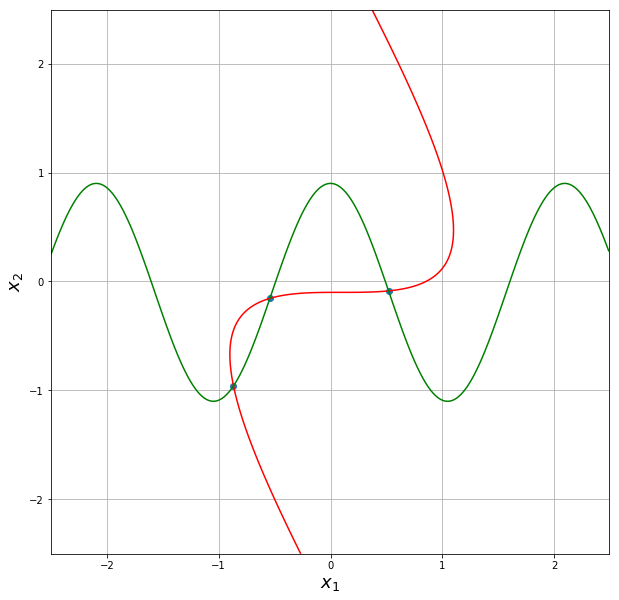

In [80]:
plt.figure(figsize=(10, 10))
plt.contour(X1, X2, f1_vals, [0], colors='r')
plt.contour(X1, X2, f2_vals, [0], colors='g')
plt.scatter(*zip(*roots))
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)
plt.grid(True)